In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.utils import shuffle
import seaborn as sns
import pickle
import calendar
import datetime
import math

In [2]:
def mean0std1normalizer(df, features,stockname):
    df = df[features]
    mean_std_dict = {}
    mu = df.mean()
    std = df.std()
    df = (df-mu)/std
    mean_std_dict[stockname] = {'mean':mu,'std':std }

    return df, mean_std_dict

In [3]:
def zero_2_one_normalizerV2(df,features,name):

    mean_std_dict = {}

    ultimate = pd.DataFrame(columns=features)
    
    subdf = df[features]
    max_ = subdf.max()
    min_ = subdf.min()
    subdf = ((subdf-min_) /(max_-min_))
    ultimate = pd.concat([ultimate, subdf])
    mean_std_dict[name] = {'min': min_, 'max': max_}

    return ultimate, mean_std_dict

In [4]:
def volume_normalizer(df):
    
    stocklist = df['Name'].unique()
    for name in stocklist:
        subdf = df[df['Name'] == name]
        sub = ((subdf['volume']-subdf['volume'].min()) /
               (subdf['volume'].max()-subdf['volume'].min())).values
        df.loc[(df['Name'] == name), 'volume'] = sub

    return df

In [5]:
def gap_transform(df, features):

    ultimate = pd.DataFrame(
        columns='open high low close volume initopen name'.split())

    stocklist = df['Name'].unique()

    for name in stocklist:
        subdf = df[df['Name'] == name]
        initopen = list(subdf['initopen'].values).copy()
        subdf = subdf[['open', 'high', 'low', 'close', 'volume']]
        test = (subdf.iloc[1:].values-subdf.iloc[:-1].values)
        test = pd.DataFrame(
            test, columns=['open', 'high', 'low', 'close', 'volume'])
        test['initopen'] = initopen[:-1]
        test['name'] = name
        ultimate = pd.concat([ultimate, test])

    return ultimate

In [6]:
def gap_transformV2(df, features):

    subdf = df[features]
    test = (subdf.iloc[1:].values-subdf.iloc[:-1].values)
    test = pd.DataFrame(test, columns=features)

    return test

In [7]:
def column_extracter(df, src_feat, trg_feat):
    '''
    src_feat : a list containing feature name of the src
    trg_feat : a list containing feature name of the trg
    output : a dictionary with column name as key and np array as value
    '''

    src_buffer_dict, trg_buffer_dict, name_buffer_dict = {}, {} ,{}

    for _ in src_feat:
        

        if df[_].dtype == object:

            name_buffer_dict[_] = df[_].to_list()

        else:

            src_buffer_dict[_] = np.array(df[_].to_list(), dtype=np.float32)

    for _ in trg_feat:

        trg_buffer_dict[_] = np.array(df[_].to_list(), dtype=np.float32)

    return src_buffer_dict, trg_buffer_dict, name_buffer_dict

In [8]:
def srctrg_splitter(src_len, trg_len, srcdict, trgdict, skipsize, name):
    
    ### temporally get rid of open price with list index 
    
    src_meta = np.vstack(
        tuple(v for k, v in srcdict.items())).astype('float32')
    trg_meta = np.vstack(
        tuple(v for k, v in trgdict.items())).astype('float32')
    
    bufferdict = {'src': [], 'trg': [], 'initopen':[], 'name':[]}

    i = 0
    max_len = src_meta.shape[1]

    while i+src_len+trg_len < max_len:
#         src_ = src_meta[:-1, i:i+src_len]
        realval = np.vstack((src_meta[:-1, i:i+src_len],np.zeros((1,src_len))))
        print(realval)
        src_ = np.hstack((np.full(
            (src_meta.shape[0]-1, 1),-.1, dtype=np.float32),src_meta[:-1, i:i+src_len]))
        trg_ = np.hstack((np.full(
            (trg_meta.shape[0], 1),-.1, dtype=np.float32), trg_meta[:, i+src_len:i+src_len+trg_len]))
#         trg_ =trg_meta[:, i+src_len-1:i+src_len+trg_len]
        price_ = src_meta[-1, i:i+1]
        bufferdict['src'].append(src_)
        bufferdict['trg'].append(trg_)
        bufferdict['initopen'].append(price_)
        bufferdict['name'].append(str(name))
        i += skipsize

    output = pd.DataFrame(bufferdict)

    return output

In [9]:
def srctrg_splitter_padded_trg(src_len, trg_len, srcdict, trgdict, skipsize, name):
    
    ### temporally get rid of open price with list index 
    
    src_meta = np.vstack(
        tuple(v for k, v in srcdict.items())).astype('float32')
    trg_meta = np.vstack(
        tuple(v for k, v in trgdict.items())).astype('float32')
    
    bufferdict = {'src': [], 'trg': [], 'initopen':[], 'name':[]}

    i = 0
    max_len = src_meta.shape[1]

    while i+src_len+trg_len < max_len:


        src_ = src_meta[:-1, i:i+src_len]
        trg_ = trg_meta[:, i+src_len:i+src_len+trg_len]
        price_ = src_meta[-1, i:i+1]
        bufferdict['src'].append(src_)
        bufferdict['trg'].append(trg_)
        bufferdict['initopen'].append(price_)
        bufferdict['name'].append(str(name))
        i += skipsize

    output = pd.DataFrame(bufferdict)

    return output

In [10]:
def srctrg_splitter_withdummy(src_len, trg_len, srcdict, trgdict, skipsize, name):
    
    ### temporally get rid of open price with list index 
    
    src_meta = np.vstack(
        tuple(v for k, v in srcdict.items())).astype('float32')
    trg_meta = np.vstack(
        tuple(v for k, v in trgdict.items())).astype('float32')
    
    bufferdict = {'src': [], 'trg': [], 'initopen':[], 'name':[]}

    i = 0
    max_len = src_meta.shape[1]

    while i+src_len+trg_len < max_len:

        realval1 = np.vstack((src_meta[:-1, i:i+src_len],np.zeros((1,src_len), dtype=np.float32)))
        realval1 = np.hstack(((np.ones((realval1.shape[0],1), dtype=np.float32)),realval1))
        realval1[:-1,0]=0
        
        realval2 = np.vstack((trg_meta[:, i+src_len:i+src_len+trg_len],np.zeros((1,trg_len), dtype=np.float32)))
        realval2 = np.hstack((np.ones((realval2.shape[0],1), dtype=np.float32),realval2))
        realval2[:-1,0]=0


#         src_ = src_meta[:-1, i:i+src_len]
#         src_ = np.hstack((np.full(
#             (src_meta.shape[0]-1, 1),-.1, dtype=np.float32),src_meta[:-1, i:i+src_len]))
#         trg_ = np.hstack((np.full(
#             (trg_meta.shape[0], 1),-.1, dtype=np.float32), trg_meta[:, i+src_len:i+src_len+trg_len]))
#         trg_ =trg_meta[:, i+src_len-1:i+src_len+trg_len]
        price_ = src_meta[-1, i:i+1]
        bufferdict['src'].append(realval1)
        bufferdict['trg'].append(realval2)
        bufferdict['initopen'].append(price_)
        bufferdict['name'].append(str(name))
        i += skipsize

    output = pd.DataFrame(bufferdict)

    return output

# Process Blocks

In [ ]:
df = pd.read_csv('techcompdata/5yrs/AAPL.csv')
# df = df.round(2)
# df = gap_transformV2(df,['Open','High','Low','Close','Volume'])
# df=(df/df.std())
df,dict_ = zero_2_one_normalizerV2(df,['Open','High','Low','Close','Volume'],'INTC')
# df=(df/df.std())
# df,dict_ = mean0std1normalizer(df,['Open','High','Low','Close','Volume'],'INTC')
print(len(df))
df.describe()


In [ ]:
for e in ['Open','High','Low','Close','Volume']:
    sns.distplot(df[e].values, kde=True, rug=False)
    plt.title(e)
    plt.show()

In [14]:
import glob
l = glob.glob('./techcompdata/5yrs/raw_data/*')
output=pd.DataFrame(columns=['Open','Close','Volume'])

for e in l:
    df = pd.read_csv(e)
    newname = e.lstrip(r'./techcompdata/5yrs/raw_data/')
    df2, _ = zero_2_one_normalizerV2(
        df, ['Open','Close','Volume'],newname)
#     df2 = gap_transformV2(df2,['Open','Close','Volume'])
    # df2=(df2-df2.mean())/df2.std()
    
#     df2, _ = zero_2_one_normalizerV2(
#         df, ['Open','Close','Volume'],newname)
    # df2=df2*2-1
    initopen = df['Open'].values
    df2['initopen'] = initopen
    df2['name'] = newname.rstrip(r'.csv')
    output=pd.concat([df2,output])
    # df2[(df2['Open']==0.0) | (df2['Volume']==0.0) | (df2['Close']==0.0)]
    df2.to_csv('./techcompdata/5yrs/0to1standardized/'+newname,index=False)
output



,Open,Close,Volume,initopen,name
0,0.139524,0.129577,0.156270,31.120001,INTC
1,0.142823,0.135446,0.129861,31.260000,INTC
2,0.154372,0.142723,0.201658,31.750000,INTC
3,0.162149,0.152817,0.197392,32.080002,INTC
4,0.169691,0.145540,0.299449,32.400002,INTC
...,...,...,...,...,...
935,0.965231,0.989949,0.100628,365.000000,TTD
936,0.929476,0.929874,0.142118,352.299988,TTD
937,0.953970,0.949833,0.097391,361.000000,TTD
938,0.910473,0.995905,0.165513,345.549988,TTD


In [15]:
import glob
l = glob.glob('./techcompdata/5yrs/0to1standardized/*')
output=pd.DataFrame(columns='Open Close Volume	initopen'.split())
for e in l:
    df1=pd.read_csv(e)
    output=pd.concat([df1,output])
# output = (output-output.mean())/output.std()

# output = output[['Open','Close', 'Volume']]
# output = output/output.std()
# output=output.round(3)
output.describe()

,Open,Close,Volume,initopen
count,21070.000000,21070.000000,21070.000000,21070.000000
mean,0.391862,0.388478,0.134024,246.614082
std,0.257564,0.257579,0.101814,371.072975
min,0.000000,0.000000,0.000000,1.620000
25%,0.160683,0.156844,0.069374,59.345000
50%,0.363898,0.358703,0.107829,124.260002
75%,0.613961,0.610298,0.166087,207.550003
max,1.000000,1.000000,1.000000,2645.000000


In [16]:
output

,Open,Close,Volume,initopen,name
0,0.139524,0.129577,0.156270,31.120001,INTC
1,0.142823,0.135446,0.129861,31.260000,INTC
2,0.154372,0.142723,0.201658,31.750000,INTC
3,0.162149,0.152817,0.197392,32.080002,INTC
4,0.169691,0.145540,0.299449,32.400002,INTC
...,...,...,...,...,...
935,0.965231,0.989949,0.100628,365.000000,TTD
936,0.929476,0.929874,0.142118,352.299988,TTD
937,0.953970,0.949833,0.097391,361.000000,TTD
938,0.910473,0.995905,0.165513,345.549988,TTD


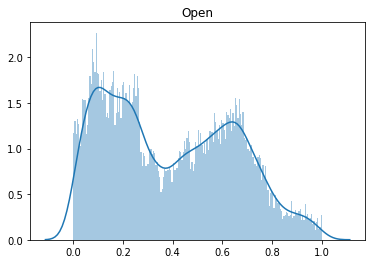

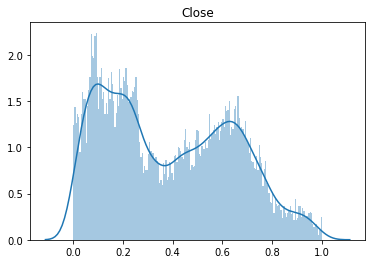

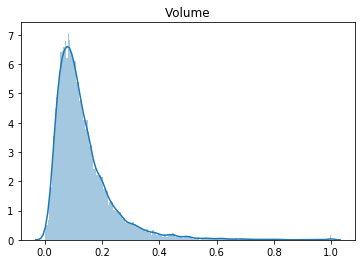

In [17]:
for e in ['Open','Close','Volume']:
    sns.distplot(output[e].values, kde=True, rug=False,bins=200)
    plt.title(e)
    plt.show()

In [31]:
final = pd.DataFrame(columns='src trg initopen name'.split())
for name in output['name'].unique():   
    srcdict, trgdict, namedict = column_extracter(output[output['name']==name],
                                                  ['Open','Close', 'Volume', 'initopen','name'],
                                                  ['Open','Close', 'Volume'])
    test = srctrg_splitter_padded_trg(90, 30, srcdict, trgdict, 1, name)
    final = pd.concat([final,test])
    final = shuffle(final)

In [32]:
final

,src,trg,initopen,name
273,"[[0.028498704, 0.034398973, 0.033550564, 0.036...","[[0.07604798, 0.07759054, 0.08464771, 0.082372...",[97.39],AAPL
72,"[[0.11026423, 0.110193044, 0.110762894, 0.1287...","[[0.023221012, 0.0, 0.034831535, 0.025500378, ...",[69.09],CRM
426,"[[0.34508634, 0.35905567, 0.34850243, 0.355212...","[[0.45671928, 0.4556213, 0.43902883, 0.4392118...",[133.6],FB
944,"[[0.3780359, 0.38155577, 0.38683563, 0.437698,...","[[0.56353396, 0.5707497, 0.5739176, 0.5723337,...",[23.1],AMD
780,"[[0.18345542, 0.18642256, 0.17759018, 0.186917...","[[0.23422998, 0.23539153, 0.22944577, 0.250342...",[301.84],TSLA
...,...,...,...,...
231,"[[0.1304197, 0.12393632, 0.12358902, 0.1216787...","[[0.29493487, 0.2849204, 0.2849204, 0.29603475...",[79.83],BABA
268,"[[0.037813094, 0.041292015, 0.041800477, 0.038...","[[0.091870055, 0.09146864, 0.09093343, 0.08667...",[94.7],NFLX
48,"[[0.00791458, 0.0029355898, 0.006820932, 0.004...","[[0.041443627, 0.04055143, 0.037529502, 0.0395...",[22.0],NVDA
1085,"[[0.47888067, 0.48011264, 0.47395283, 0.478352...","[[0.91182685, 0.94280183, 0.938402, 0.99208033...",[28.83],AMD


In [20]:
final.to_pickle('techcompdata/5yrs/srctrg_set90_30VOC_trgpad2.pkl')

In [33]:
df=pd.read_pickle('techcompdata/5yrs/srctrg_set90_30VOC_trgpad2.pkl')
# df=shuffle(df)
df

,src,trg,initopen,name
1026,"[[0.5609239, 0.58449215, 0.582371, 0.572708, 0...","[[0.76596755, 0.78435075, 0.7791657, 0.7610182...",[49.0],INTC
643,"[[0.6139815, 0.6396023, 0.6580247, 0.6622338, ...","[[0.6577198, 0.67516625, 0.6579028, 0.6507045,...",[177.68],FB
76,"[[0.5802059, 0.5314646, 0.5860413, 0.62311214,...","[[0.3478261, 0.27665904, 0.28215107, 0.3115561...",[145.31],IBM
396,"[[0.16833645, 0.16770604, 0.16638224, 0.169376...","[[0.23443726, 0.2425603, 0.24308261, 0.2480446...",[798.0],AMZN
1063,"[[0.4609697, 0.47132146, 0.46540612, 0.4820957...","[[0.5851907, 0.5874089, 0.61244327, 0.6143446,...",[98.03],EA
...,...,...,...,...
745,"[[0.16507767, 0.17483008, 0.17869425, 0.181914...","[[0.12987475, 0.14063917, 0.13249686, 0.136487...",[285.86],TSLA
426,"[[0.17905207, 0.18271568, 0.17704679, 0.181790...","[[0.20998032, 0.2116386, 0.20704949, 0.2044657...",[136.43],AAPL
34,"[[0.0054558255, 0.009855685, 0.008623724, 0.00...","[[0.013199578, 0.013023583, 0.013903555, 0.013...",[1.93],AMD
265,"[[0.07783515, 0.0814003, 0.086805515, 0.089289...","[[0.056041766, 0.04820995, 0.052534122, 0.0465...",[210.0],TSLA


In [ ]:
df = pd.read_csv('techcompdata/IBM.csv')
df = gap_transformV2(df,['Open','High','Low','Close','Volume'])
stdrecord.loc['IBM']=df.std().values

In [ ]:
stdrecord=pd.DataFrame(columns=['Open','High','Low','Close','Volume'],
                      index='IBM AMD INTC'.split())

In [ ]:
stdrecord.to_csv('techcompdata/stdrecord.csv',)

In [ ]:
pd.read_csv('techcompdata/stdrecord.csv')

In [ ]:
stdrecord